Ecommerce Analytics Project

Objective:
Analyze ecommerce order and payment data to understand:
- Customer purchasing behavior
- Sales trends over time
- Product category performance
- Order patterns across cities

Tools:
Python, SQL (MySQL), pandas, seaborn

In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv','geolocation')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='AhW3d!459',
    database='mirdb'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:\\Users\\ASUS\\Desktop\\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "AhW3d!459",
                             database = "mirdb")

cur = db.cursor() 

#List unique cities from the table 

In [ ]:
query = """SELECT DISTINCT customer_city FROM customers"""

cur = db.cursor() 
cur.execute(query)
data = cur.fetchall()
data

#count the number of orders placed in 2017

In [4]:
query = """
SELECT COUNT(order_id)
FROM orders
WHERE YEAR(STR_TO_DATE(order_purchase_timestamp, '%Y-%m-%d %H:%i:%s')) = 2017
"""

cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

#count the numebr of customers for each state 

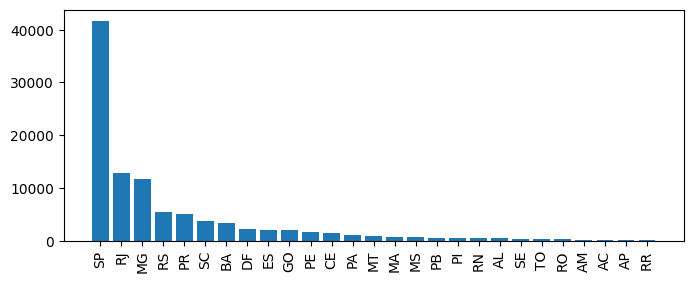

In [8]:
query = """ select customer_state,count(customer_id)
from customers group by customer_state"""


cur = db.cursor()
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count",ascending = False )

plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

#calculate the number of orders that were paid in installments 

In [9]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0
end))/count(*)*100 from payments"""


cur = db.cursor()
cur.execute(query)

data = cur.fetchall()
"the percantage of orders that were placed in installments is",data[0][0]

('the percantage of orders that were placed in installments is',
 Decimal('99.9981'))

#Find Total Sales Per Category 

In [14]:
query = """ SELECT 
    products.product_category AS category,
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM products
JOIN order_items
    ON products.product_id = order_items.product_id
JOIN payments
    ON payments.order_id = order_items.order_id
GROUP BY products.product_category"""


cur = db.cursor()
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","sales"])
df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


#Calculate the number of orders per month in 2018 

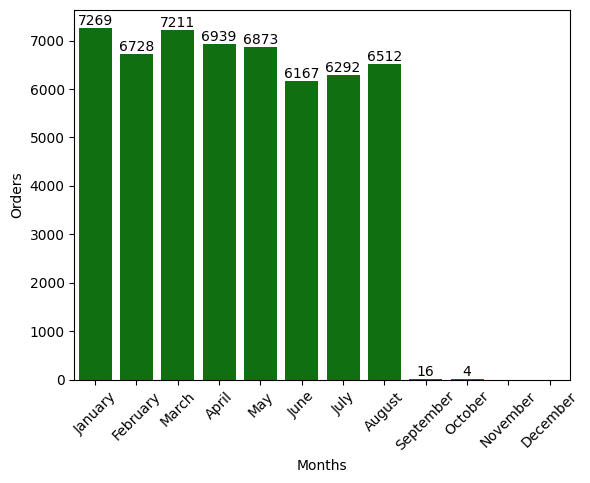

In [14]:
query = """select monthname(order_purchase_timestamp)months, count(order_id)
order_count from orders where year(order_purchase_timestamp)=2018 
group by months"""

cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months","Orders"])
o = ["January","February","March","April","May","June","July","August",
     "September","October","November","December"]

ax = sns.barplot(x = df["Months"],y= df["Orders"],data=df,order=o,color = "green")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()

#Find the Average number of product per orders gruopede by customer city 

In [10]:
query = """with count_per_order as (select orders.order_id,orders.customer_id,
count(order_items.order_id)as oc from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order on customers.customer_id = 
count_per_order.customer_id group by customers.customer_city"""

cur = db.cursor()
cur.execute(query)
data = cur.fetchall()                                                        # Insight:
df = pd.DataFrame(data,columns = ["City","Avg Orders"])                      # Customers across most cities purchase ~1–1.3 items per order,
df.head(10)                                                                  # indicating low basket size and an opportunity for cross-selling.

,City,Avg Orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


#Calculate the percentage of total revenue contributed by each product category 

In [13]:
query = """select
    upper(products.product_category) as category,
    round(
        (sum(payments.payment_value) /
         (select sum(payment_value) from payments)
        ) * 100
    ) as sales_percentage
from products
join order_items
    on products.product_id = order_items.product_id
join payments
    on payments.order_id = order_items.order_id
group by category
order by sales_percentage DESC;
"""

cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["City","Avg Orders"])
df.head(10)

,City,Avg Orders
0,BED TABLE BATH,11.0
1,COMPUTER ACCESSORIES,10.0
2,HEALTH BEAUTY,10.0
3,FURNITURE DECORATION,9.0
4,WATCHES PRESENT,9.0
5,SPORT LEISURE,9.0
6,HOUSEWARES,7.0
7,AUTOMOTIVE,5.0
8,COOL STUFF,5.0
9,GARDEN TOOLS,5.0


#Identify the correlation between product pirce and the number of times the product has been purchased

In [8]:
import numpy as np
query = """select
    products.product_category,
    count(order_items.product_id),
    round(AVG(order_items.price), 2)
from products
join order_items
    on products.product_id = order_items.product_id
group by products.product_category;
"""

cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","order_count","price"])

a = df["order_count"]
a1 = df["price"]

b = np.corrcoef([a,a1])
print("The Correlation between price and number of times a product has been pruchased is",b[0][-1])

The Correlation between price and number of times a product has been pruchased is -0.10631514167157562


#Calculate the total revenue generated by each seller and rank them by revenue

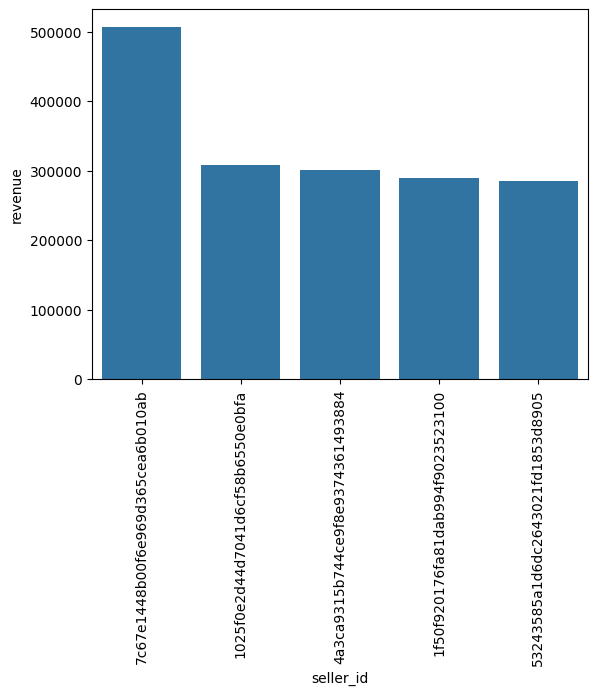

In [14]:
query = """select *,dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""


cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id",y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

#Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(
    partition by customer_id
    order by order_purchase_timestamp
    rows between 2 preceding and current row
) as mov_avg
from
(
    select orders.customer_id,
           orders.order_purchase_timestamp,
           payments.payment_value as payment
    from payments join orders
    on payments.order_id = orders.order_id
) as a"""



cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_ID","History","price","Avg"])
df.head(10)

,customer_ID,History,price,Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


#Calculate the cumulative sales per month for each year.

In [20]:
query = """select years, months, payment,
sum(payment) over(order by years, months) cumulative_sales
from
(
    select year(orders.order_purchase_timestamp) as years,
           month(orders.order_purchase_timestamp) as months,
           round(sum(payments.payment_value), 2) as payment
    from orders join payments
    on orders.order_id = payments.order_id
    group by years, months
    order by years, months
) as a
"""
cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


#Calculate the year-over-year growth rate of total sales.

In [27]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value), 2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years
order by years)
select years,((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a """


cur = db.cursor()
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Years","YOY % growth"])
df

,Years,YOY % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


#Calculate the retention rate of customers, defined as the percentage of Customers with a 2nd order within 6 months of first order

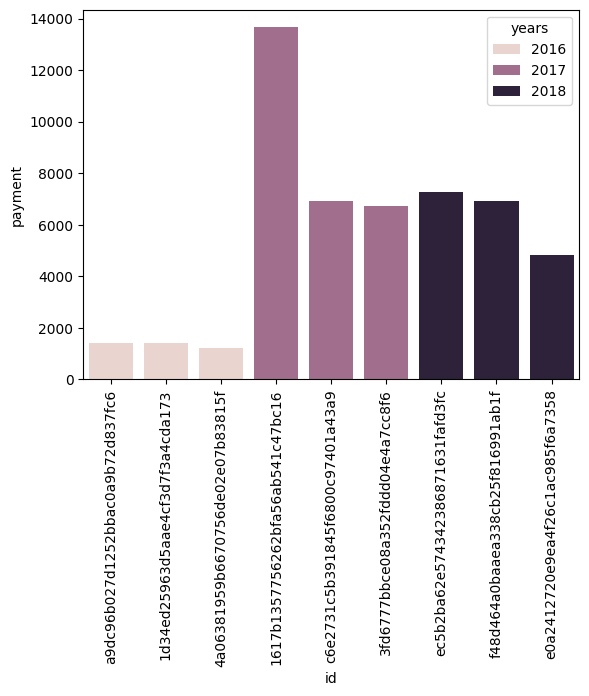

In [28]:
query = """select years, customer_id, payment, d_rank
from
(
    select year(orders.order_purchase_timestamp) years,
           orders.customer_id,
           sum(payments.payment_value) payment,
           dense_rank() over(
               partition by year(orders.order_purchase_timestamp)
               order by sum(payments.payment_value) desc
           ) d_rank
    from orders join payments
    on payments.order_id = orders.order_id
    group by year(orders.order_purchase_timestamp),
             orders.customer_id
) as a
where d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])

sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()
